In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import train_test_split

#Reading the CSV file, remember to parse the timestamp column as dates so it can be recognized as date format
#also make it the index so it can be sliced by dates easily
#Renaming the columns so they are more easy to identify and call is also a good idea.
df = pd.read_csv('Usecase3data.csv', parse_dates=['timestamp'], index_col='timestamp')
df.columns = ['Debit1','Debit2','Debit3','Debit4','Puissance1','Puissance2']

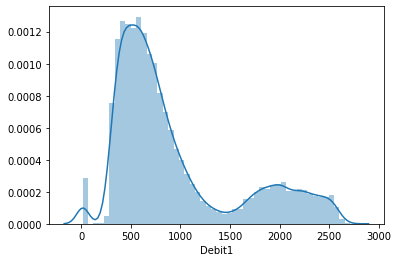

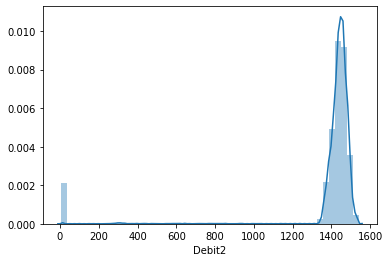

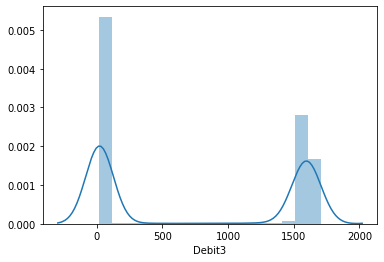

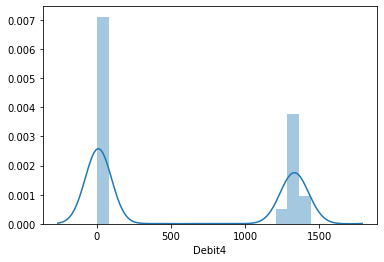

<Figure size 432x288 with 0 Axes>

In [2]:

#Calculating important parameters for this problem; Total flow, power and efficiency
TotalFlow = df.Debit1 + df.Debit2 + df.Debit3 + df.Debit4 
TotalPower = df.Puissance1 + df.Puissance2
Efficiency = TotalPower/TotalFlow
#TotalPower.plot()
#TotalFlow.plot()

# Adding these parameters into the dataframe
df['TotalFlow'] = TotalFlow
df['TotalPower'] = TotalPower
df['Efficiency'] = Efficiency

# To see the behaviour of each compressor it is useful to visualize their flow distributions
# We notice that the first compressor has a flow distribution that goes from approximately 200 to close to 3000
# the client confirmed that this is a variable speed compressor.
# The other 3 compressors are fixed speed and show behaviour in flows greater than 1000

DistComp1 = sns.distplot(df.Debit1)
plt.figure()
DistComp2 = sns.distplot(df.Debit2)
plt.figure()
DistComp3 = sns.distplot(df.Debit3)
plt.figure()
DistComp4 = sns.distplot(df.Debit4)
plt.figure()

# Finding whether the compressors are on or off; if they are "On" make the LoadComp variable equal to 1
loadComp1 = ((df['Debit1'] > 200)*1)
loadComp2 = ((df['Debit2'] > 1000)*1)
loadComp3 = ((df['Debit3'] > 1000)*1)
loadComp4 = ((df['Debit4'] > 1000)*1)

# Discretization of compressor state into sequences. We multiply a power of 2 to each LoadComp variable
# and add them, this way we can relate the sequence value to the state of each compressor (binary table)
sequence = (loadComp1 + 2*loadComp2 + 4*loadComp3 + 8*loadComp4)
df['sequence'] = sequence

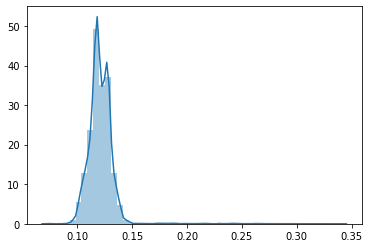

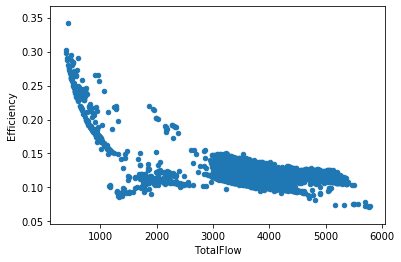

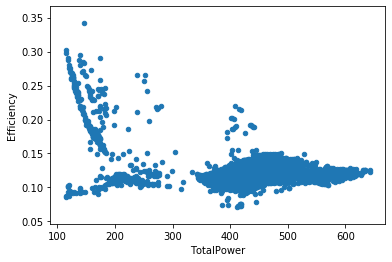

In [3]:
# To visualize, it is good to do a distirbution plot of the efficiency, to find where the most part of the points are.

sns.distplot(Efficiency)

# Scatter plots of total flow vs efficiency and total power vs efficiency give us an idea of how are 
# these variables related.


var = 'TotalFlow'
data = pd.concat([df['Efficiency'], df[var]], axis=1)
data.plot.scatter(x=var, y='Efficiency');

var = 'TotalPower'
data = pd.concat([df['Efficiency'], df[var]], axis=1)
data.plot.scatter(x=var, y='Efficiency');

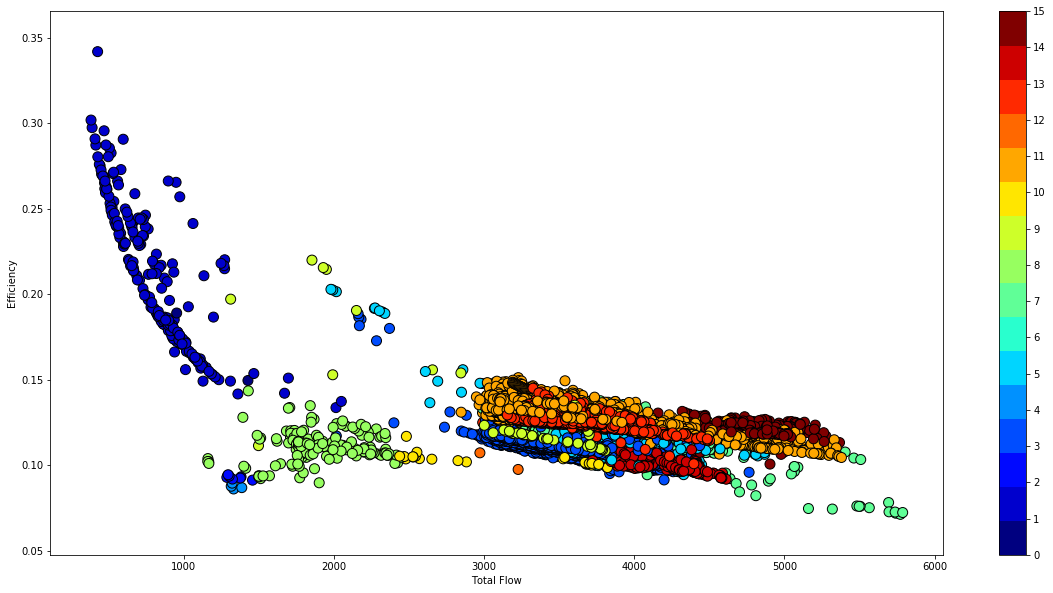

In [4]:
# To find the optimal sequences, a scatterplot relating flow and efficiency is done.
# Each point of the plot is colored according to the sequence in which it is working,
# in this way we can visualize the efficiency given by each sequence.

var = 'TotalFlow'
plt.figure(figsize=(20,10))
plt.scatter(df[var], df['Efficiency'], \
            c=df['sequence'], cmap=plt.cm.get_cmap('jet', 16), s= 100,edgecolors= "black")
plt.colorbar(ticks=range(16))
#plt.legend(df['sequence'])
plt.xlabel('Total Flow')
plt.ylabel('Efficiency')

plt.show()


In [6]:
# After observing, we find the best sequences for different flow ranges, a list containing this optimal sequences is created
# by slicing the original dataframe with the new conditions

OptSeq =  ((df.TotalFlow < 1300) & (df.sequence == 1))\
    | (((df.TotalFlow > 1300) & (df.TotalFlow <= 2400)) & (df.sequence == 8)
    | (((df.TotalFlow > 2400) & (df.TotalFlow <= 3800)) & (df.sequence == 3)
    | (((df.TotalFlow > 3800) & (df.TotalFlow <= 4700)) & (df.sequence == 14) 
    | (((df.TotalFlow > 4700) & (df.sequence == 7) 
      )))))
# The independent and dependent variables for regression are defined from the optimized sequence values.

X = df[OptSeq].TotalFlow.values.reshape(-1,1)
Y = df[OptSeq].TotalPower.values.reshape(-1,1)


# The dataset is splitted in training and test subsets, i'll be using 80% of data for training.
train_pct_index = int(0.8 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
Y_train, Y_test = Y[:train_pct_index], Y[train_pct_index:]

# Linear regression is called from the scikitlearn library and is training with the previously splitted train data.
reg = linear_model.LinearRegression()
reg.fit(X_train,Y_train)

#
print ("The model has an R² coefficient of: ",round(reg.score(X_test,Y_test),2))
print ("The average power consumed before optimization is: ",round(df.TotalPower.mean(),2),"kWh")
dfn = df.fillna(df.mean())
TotalPower_pred = reg.predict(dfn.TotalFlow.values.reshape(-1,1))
print ("The average power with the optimized sequences is: ", round(TotalPower_pred.mean(),2),"kWh")

savings = ((df.TotalPower.mean()-TotalPower_pred.mean())/df.TotalPower.mean())*100
print ("The savings are estimated about of: ", round(savings,2),"%")

The model has an R² coefficient of:  0.86
The average power consumed before optimization is:  432.11 kWh
The average power with the optimized sequences is:  395.39 kWh
The savings are estimated about of:  8.5 %
